In [1]:
import sys; sys.path.append('../../wwa'); from wwa import *

xn,xx,yn,yx = [-15,30,35,60]

In [2]:
# load daily data
da = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/EUR_heat/era5_t2m.nc").t2m

In [3]:
da = da.sel(lon = slice(xn,xx), lat = slice(yx,yn))

In [ ]:
# da = convert_units_to(da, "degC")
da = (da - 273.15).assign_coords(units = "degC")

In [150]:
px = pd.read_csv("city_coords.csv", index_col = 0).dropna(axis = 0, how = "all").dropna(axis = 1, how = "all")

In [123]:
t_cities = {v["City name"] : da.sel(lon = v["lon"], lat = v["lat"], method = "nearest", drop = True).rolling(time = 5).mean() for k,v in px.iterrows()}

In [18]:
days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(len(days)) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[:3] for i in range(len(days)) if (days[i].day) == 15]

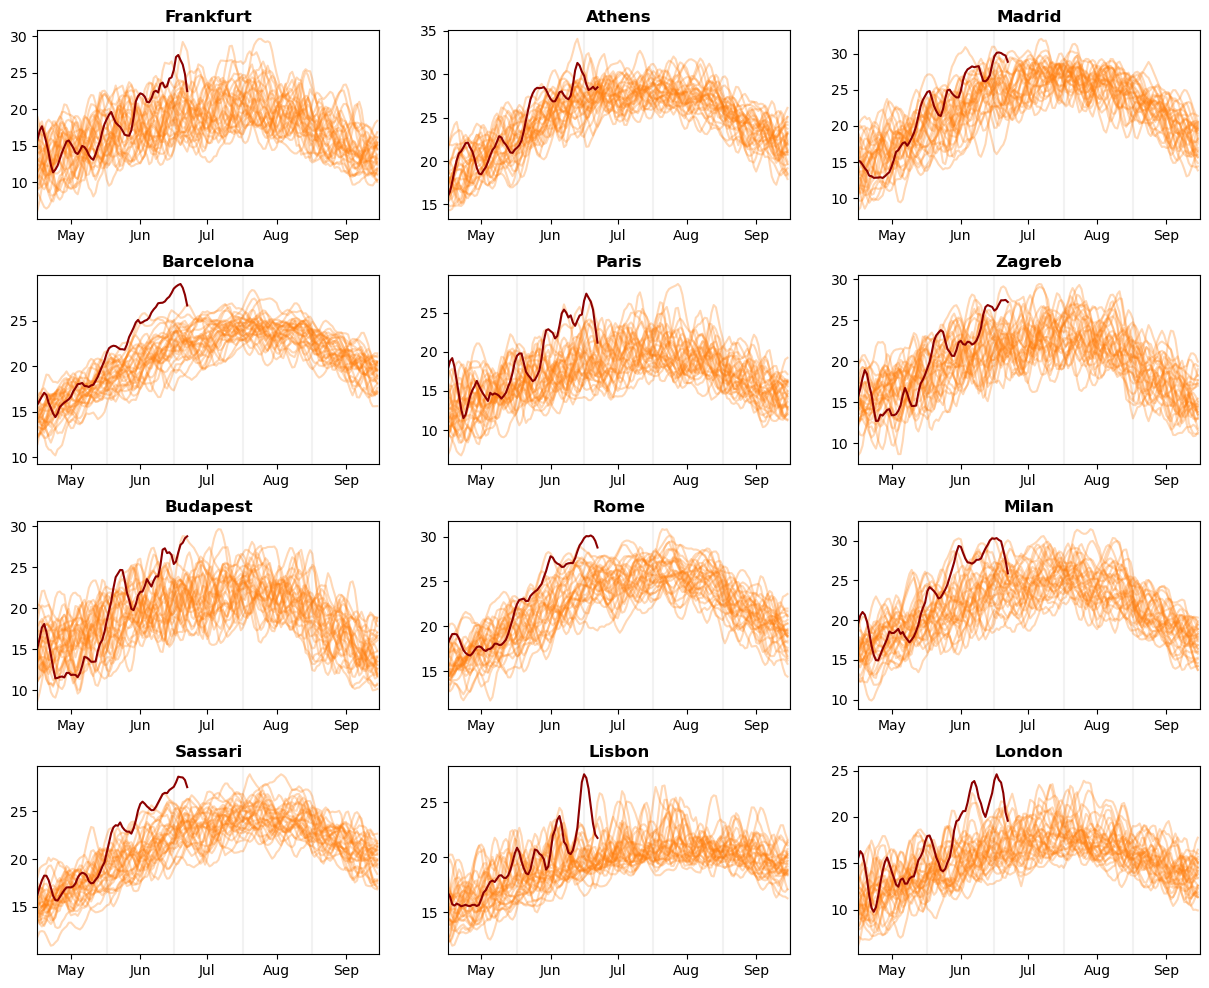

In [19]:
nc = 3; nr = 4
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 3), dpi = 100)
plt.subplots_adjust(hspace = 0.3)

for i in range(min(nc*nr, len(t_cities))):
    c = list(t_cities.keys())[i]
    ts = t_cities[c]
    ax = axs.flatten()[i]
    
    ts = ts.sel(time = ts.time.dt.dayofyear.isin(range(121,274)))
    
    for y in range(1990,2020):
        ts_y = ts.loc[str(y)]
        ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:orange", alpha = 0.3, label = "_years")
    
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(len(days)) if (days[x].day) == 1]
    
#     ax.plot(ts.loc["2022"].time.dt.dayofyear, ts.loc["2022"], color = "k", ls = ":")
    ax.plot(ts.loc["2025"].time.dt.dayofyear, ts.loc["2025"], color = "darkred")
    ax.set_title(c, fontweight = "bold")
    
    ax.set_xlim(121,274)

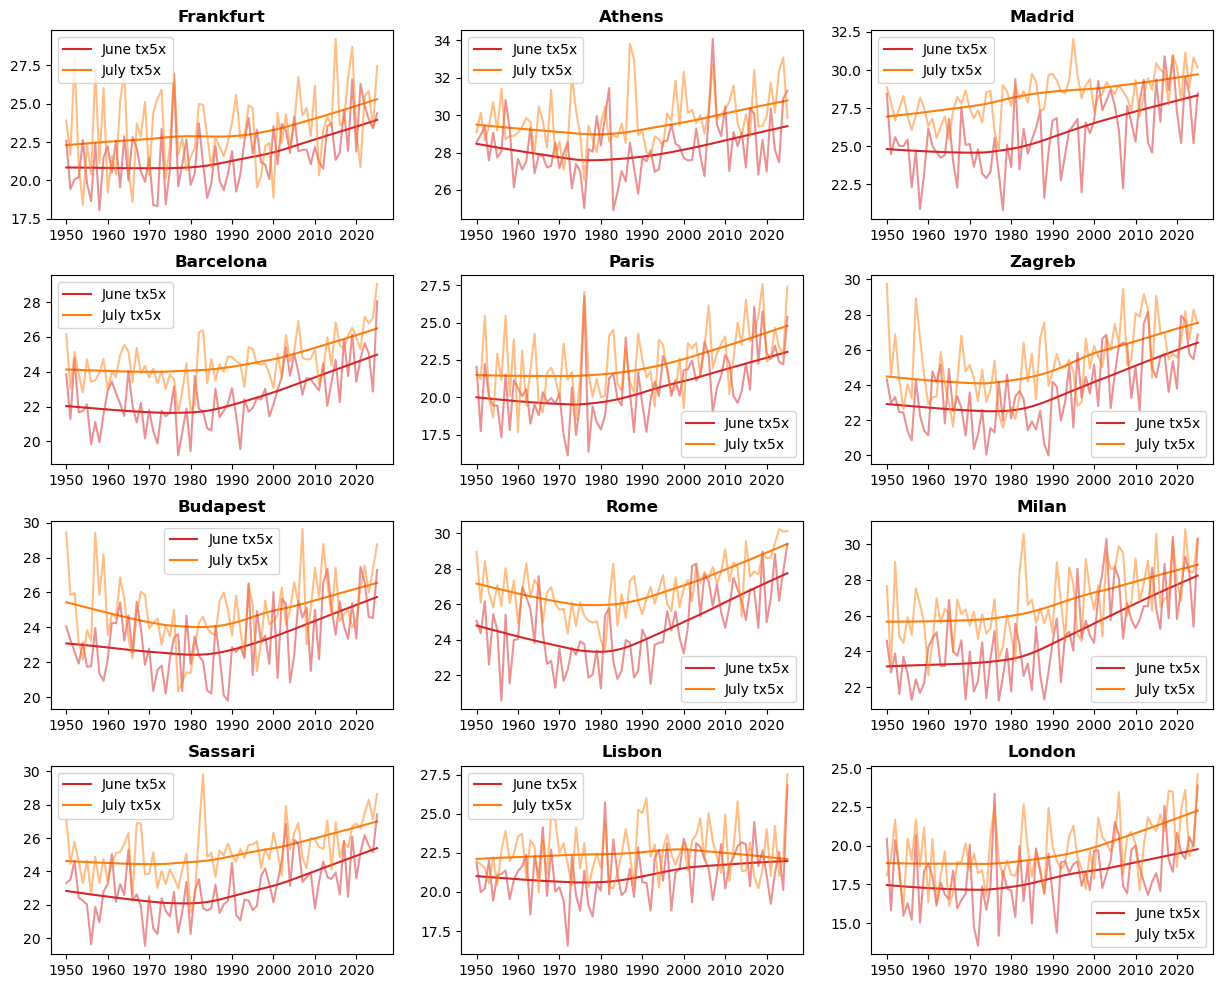

In [15]:
nc = 3; nr = 4
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 3), dpi = 100)
plt.subplots_adjust(hspace = 0.3)

for i in range(min(nc*nr, len(t_cities))):
    c = list(t_cities.keys())[i]
    tx_jun = t_cities[c].rolling(time = 5).mean().groupby("time.month")[6].resample(time = "AS").max()
    tx_jul = t_cities[c].rolling(time = 5).mean().groupby("time.month")[7].resample(time = "AS").max()
    ax = axs.flatten()[i]
       
    ax.plot(tx_jun.time, lowess(tx_jun.values,tx_jun.time)[:,1], label = "June", color = "tab:red")
    ax.plot(tx_jul.time, lowess(tx_jul.values, tx_jul.time)[:,1], label = "July", color = "tab:orange")
    
    ax.plot(tx_jun.time, tx_jun.values, label = "June", color = "tab:red", alpha = 0.5)
    ax.plot(tx_jul.time, tx_jul, label = "July", color = "tab:orange", alpha = 0.5)
    
    ax.set_title(c, fontweight = "bold")
    ax.legend(["June tx5x", "July tx5x"])

In [8]:
gmst = pd.read_table("gmst.txt", comment = "#", sep = " +", engine = "python", header = None, names = ["year", "gmst"], index_col = "year").to_xarray().gmst
gmst = gmst.sel(year = slice(1950,2025))

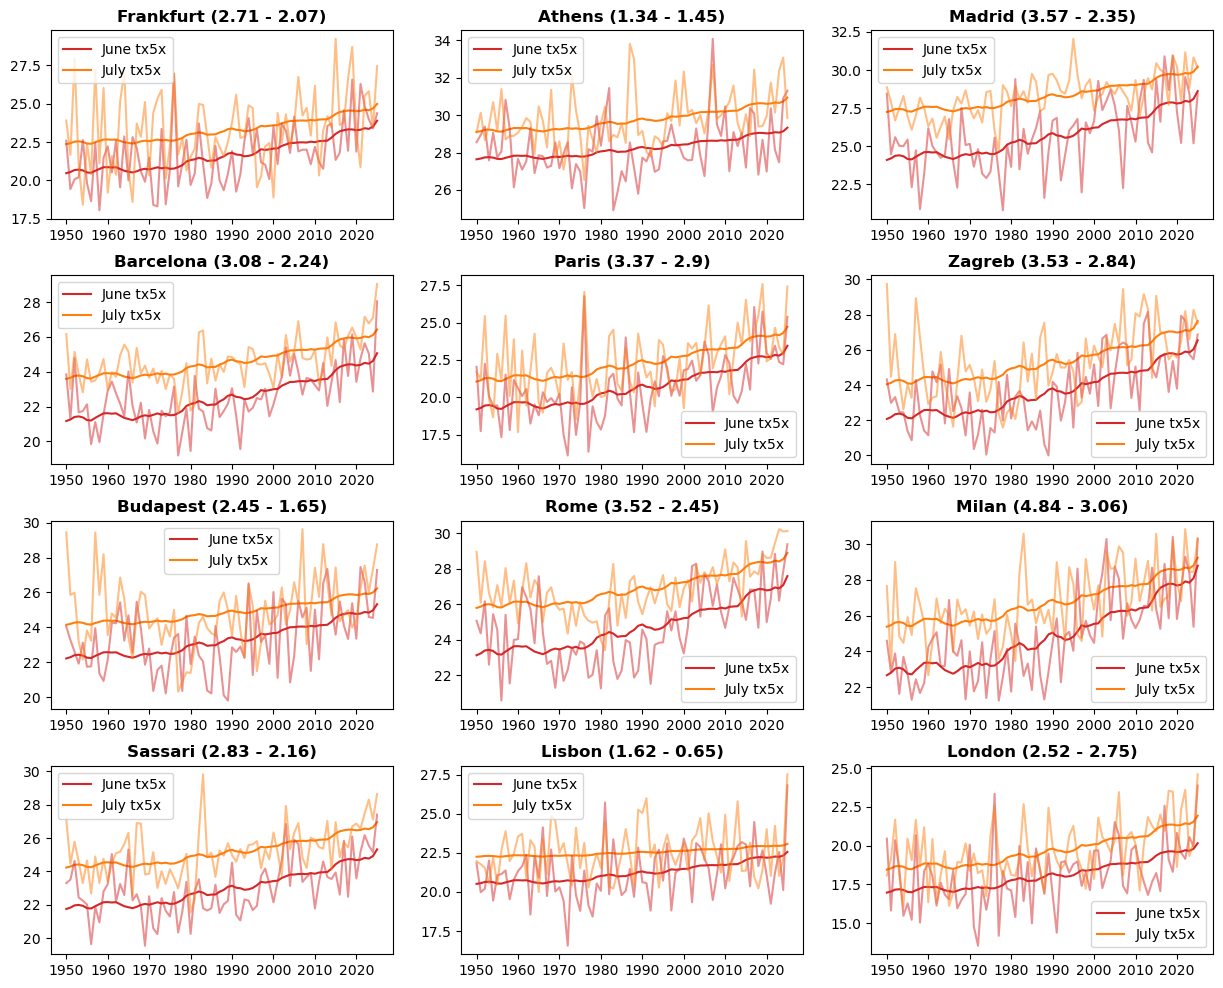

In [16]:
nc = 3; nr = 4
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 3), dpi = 100)
plt.subplots_adjust(hspace = 0.3)

for i in range(min(nc*nr, len(t_cities))):
    c = list(t_cities.keys())[i]
    tx_jun = t_cities[c].rolling(time = 5).mean().groupby("time.month")[6].resample(time = "AS").max()
    tx_jul = t_cities[c].rolling(time = 5).mean().groupby("time.month")[7].resample(time = "AS").max()
    ax = axs.flatten()[i]
    
    coef_jun = tx_jun.assign_coords(time = gmst.values).polyfit("time", deg = 1).polyfit_coefficients
    coef_jul = tx_jul.assign_coords(time = gmst.values).polyfit("time", deg = 1).polyfit_coefficients

    ax.plot(tx_jun.time, xr.polyval(gmst, coef_jun), label = "June", color = "tab:red")
    ax.plot(tx_jul.time, xr.polyval(gmst, coef_jul), label = "July", color = "tab:orange")
    
    ax.plot(tx_jun.time, tx_jun.values, label = "June", color = "tab:red", alpha = 0.5)
    ax.plot(tx_jul.time, tx_jul, label = "July", color = "tab:orange", alpha = 0.5)
    
    ax.set_title(c+" ("+str(coef_jun.sel(degree = 1).round(2).values)+" - "+str(coef_jul.sel(degree = 1).round(2).values)+")", fontweight = "bold")
    ax.legend(["June tx5x", "July tx5x"])

In [63]:
df = merge_byindex([da.to_dataframe().rename(columns = {"t2m" : k}).rolling(5).mean().resample("MS").max() for k, da in t_cities.items()])
df.to_csv("tx5x-monthly_era5_cities.csv")

# Bootstrapped changes in intensity in June & July

In [155]:
city_order = list(px["City name"])

In [161]:
fl = sorted(glob.glob("full-bootstrap*.csv"))
df = pd.concat([pd.read_csv(fnm, index_col = 0).loc[["alpha_gmst"]] for fnm in fl])
df.index = [fnm.split("_")[3] for fnm in fl]
df = df.loc[city_order]

In [162]:
fl = sorted(glob.glob("compare*.csv"))
ests = pd.concat([pd.read_csv(fnm, index_col = 0).loc[:,["alpha_gmst"]].transpose() for fnm in fl])
ests.index = [fnm.split("_")[2] for fnm in fl]
ests = ests.loc[city_order]

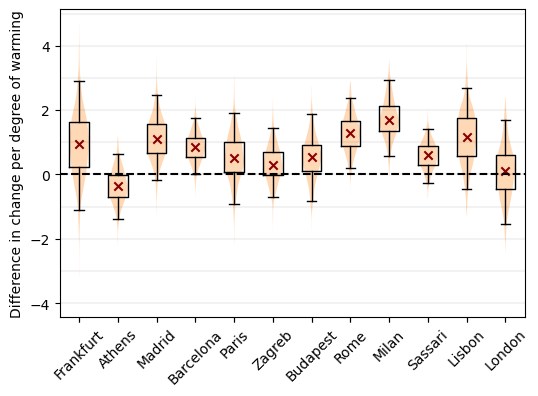

In [163]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

vparts = ax.violinplot(df.transpose(), showmeans = False, showmedians = False, showextrema = False)
for pc in vparts['bodies']:
    pc.set_facecolor('tab:orange')

ax.scatter(range(1,13), ests["50%"], color = "darkred", marker = "x")
# ax.scatter(range(1,13), ests["est"], color = "k", marker = "x")
# ax.scatter(range(1,13), ests["2.5%"], color = "darkred", marker = "x")
# ax.scatter(range(1,13), ests["97.5%"], color = "darkred", marker = "x")


ax.set_xticks(range(1,13))
ax.set_xticklabels(df.index)
ax.tick_params("x", rotation=45)
ax.set_ylabel("Difference in change per degree of warming")
ax.boxplot(df.transpose(), labels = list(df.index), meanline = False, showmeans = False, zorder = 3, whis = (2.5,97.5),
           meanprops = {"color" : "none"}, medianprops = {"color" : "none"}, flierprops = {"marker" : ""})
[ax.axhline(y, color = "k", alpha = 0.05) for y in range(-4,6)]

ax.axhline(0, color = "k", ls = "--")

In [165]:
tx5x = pd.read_csv("tx5x-monthly_era5_cities.csv", index_col = "time", parse_dates = ["time"])

In [166]:
fl = sorted(glob.glob("compare*.csv"))
alpha_june = pd.concat([pd.read_csv(fnm, index_col = 0).loc[:,["jun_alpha_gmst"]].transpose() for fnm in fl])
alpha_june.index = [fnm.split("_")[2] for fnm in fl]

alpha_july = pd.concat([pd.read_csv(fnm, index_col = 0).loc[:,["jul_alpha_gmst"]].transpose() for fnm in fl])
alpha_july.index = [fnm.split("_")[2] for fnm in fl]

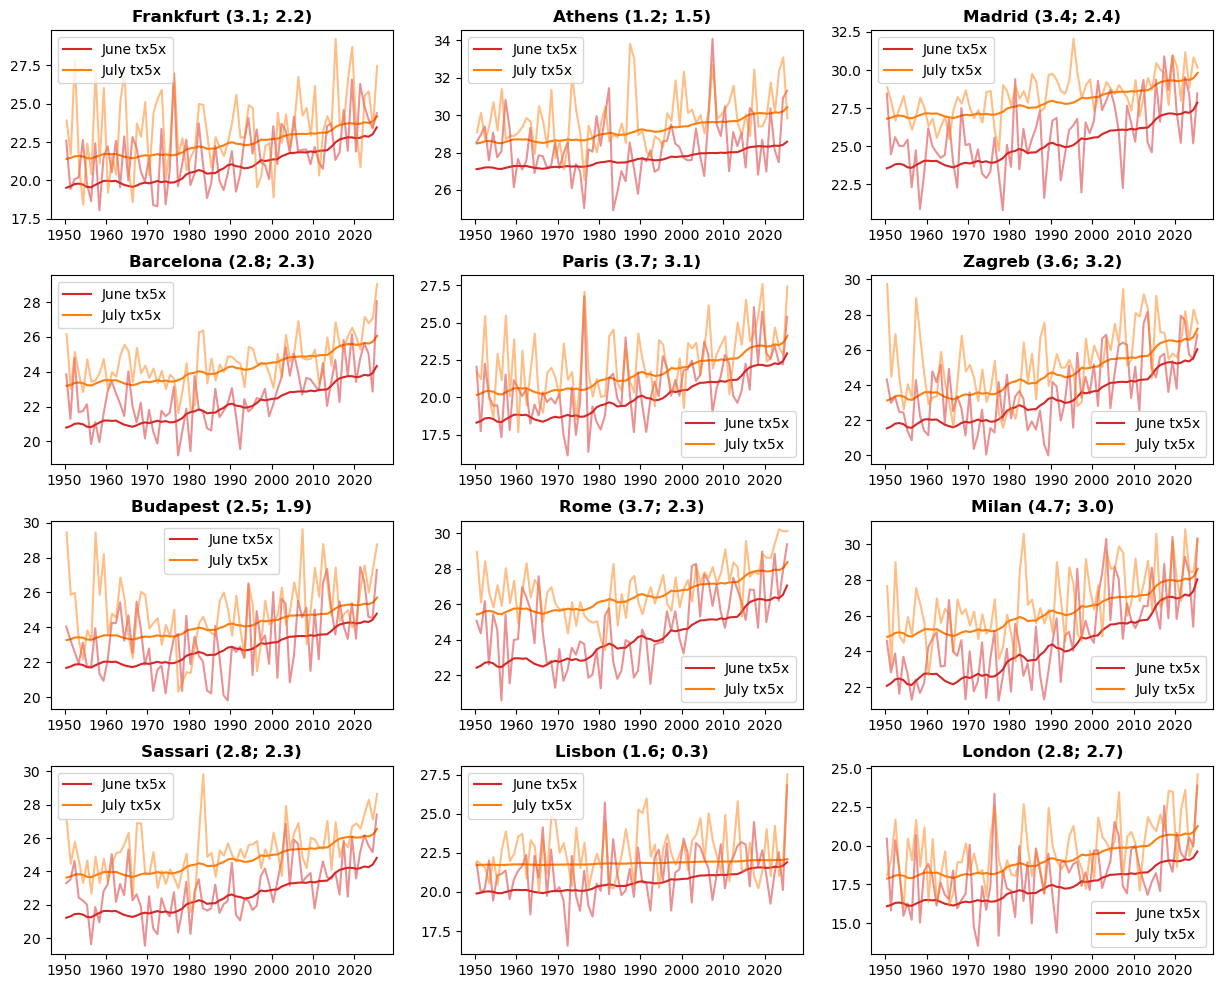

In [191]:
nc = 3; nr = 4
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 3), dpi = 100)
plt.subplots_adjust(hspace = 0.3)

for i in range(min(nc*nr, len(t_cities))):
    c = city_order[i]
    ax = axs.flatten()[i]
    
    fitted = pd.read_csv("fitted-values-jj_tg5x_"+c+"_era5.csv", index_col = "year")
    
    tx_jun = tx5x.loc[tx5x.index.month == 6,[c]]
    tx_jul = tx5x.loc[tx5x.index.month == 7,[c]]

    ax.plot([datetime(y,6,1) for y in fitted.index], fitted.june, label = "June", color = "tab:red")
    ax.plot([datetime(y,7,1) for y in fitted.index], fitted.july, label = "June", color = "tab:orange")
    
    ax.plot(tx_jun.index, tx_jun, label = "June", color = "tab:red", alpha = 0.5)
    ax.plot(tx_jul.index, tx_jul, label = "July", color = "tab:orange", alpha = 0.5)
    
    ax.set_title(c+" ("+str(alpha_june.loc[c,"est"].round(1))+"; "+str(alpha_july.loc[c,"est"].round(1))+")", fontweight = "bold")
    ax.legend(["June tx5x", "July tx5x"])

In [9]:
da = xr.open_dataset("era5_t2m.nc").t2m

In [10]:
t2m_clim = da.resample(time = "QS-DEC").mean().groupby("time.season")["JJA"].mean()

In [11]:
t2m_2025 = da.sel(time = slice("2025-06-25", "2025-07-02")).mean("time")

In [16]:
t2m_2025 = da.sel(time = slice("2025-06-01",None)).rolling(time = 5).mean().sel(time = slice("2025-06-25", "2025-07-02")).max("time")

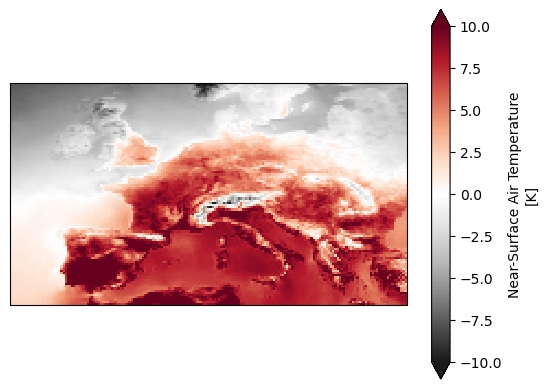

In [17]:
(t2m_2025 - t2m_clim).plot(cmap = "RdGy_r", vmin = -10, vmax = 10, subplot_kws = {"projection" : cartopy.crs.PlateCarree()})

In [ ]:
da_hotdays = da.sel(time = da.time.dt.dayofyear.isin(range(176,184)))

In [3]:
da = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/EUR_heat/gridded-trend_tg5x_era5.nc")

In [9]:
da.alpha_gmst.to_netcdf("change-per-deg-gmst.nc")

In [10]:
xr.open_dataset("change-per-deg-gmst.nc")

<xarray.Dataset>
Dimensions:     (lon: 181, lat: 101)
Coordinates:
  * lon         (lon) float64 -15.0 -14.75 -14.5 -14.25 ... 29.5 29.75 30.0
  * lat         (lat) float64 60.0 59.75 59.5 59.25 ... 35.75 35.5 35.25 35.0
Data variables:
    alpha_gmst  (lat, lon) float32 ...